<a href="https://colab.research.google.com/github/lamiaa5788/COVID-19/blob/master/gan_and_dataset_worked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nabeelsajid917/covid-19-x-ray-10000-images
from zipfile import ZipFile
file_name="covid-19-x-ray-10000-images.zip"
with ZipFile(file_name,'r')as zip:
  zip.extractall()
  print('Done')

Saving kaggle.json to kaggle.json
 96% 89.0M/92.7M [00:01<00:00, 41.1MB/s]
100% 92.7M/92.7M [00:01<00:00, 52.0MB/s]
Done


In [ ]:
try:

    import tensorflow as tf
    import cv2
    import os
    import pickle
    import numpy as np
    print("Library Loaded Successfully ..........")
except:
    print("Library not Found ! ")


class MasterImage(object):

    def __init__(self,PATH='../content/dataset', IMAGE_SIZE = 128):
        self.PATH = PATH
        self.IMAGE_SIZE = IMAGE_SIZE

        self.image_data = []
        self.x_data = []
        self.y_data = []
        self.CATEGORIES = []

        # This will get List of categories
        self.list_categories = []

    def get_categories(self):
        for path in os.listdir(self.PATH):
            if '.DS_Store' in path:
                pass
            else:
                self.list_categories.append(path)
        print("Found Categories ",self.list_categories,'\n')
        return self.list_categories

    def Process_Image(self):
        try:
            """
            Return Numpy array of image
            :return: X_Data, Y_Data
            """
            self.CATEGORIES = self.get_categories()
            for categories in self.CATEGORIES:                                                  # Iterate over categories

                train_folder_path = os.path.join(self.PATH, categories)                         # Folder Path
                class_index = self.CATEGORIES.index(categories)                                 # this will get index for classification

                for img in os.listdir(train_folder_path):                                       # This will iterate in the Folder
                    new_path = os.path.join(train_folder_path, img)                             # image Path

                    try:        # if any image is corrupted
                        image_data_temp = cv2.imread(new_path,cv2.IMREAD_GRAYSCALE)                 # Read Image as numbers
                        image_temp_resize = cv2.resize(image_data_temp,(self.IMAGE_SIZE,self.IMAGE_SIZE))
                        self.image_data.append([image_temp_resize,class_index])
                    except:
                        pass

            data = np.asanyarray(self.image_data)

            # Iterate over the Data
            for x in data:
                self.x_data.append(x[0])        # Get the X_Data
                self.y_data.append(x[1])        # get the label

            X_Data = np.asarray(self.x_data) / (255.0)      # Normalize Data
            Y_Data = np.asarray(self.y_data)

            # reshape x_Data

            X_Data = X_Data.reshape(-1, self.IMAGE_SIZE, self.IMAGE_SIZE, 1)

            return X_Data, Y_Data
        except:
            print("Failed to run Function Process Image ")

    def pickle_image(self):

        """
        :return: None Creates a Pickle Object of DataSet
        """
        # Call the Function and Get the Data
        X_Data,Y_Data = self.Process_Image()

        # Write the Entire Data into a Pickle File
        pickle_out = open('X_Data','wb')
        pickle.dump(X_Data, pickle_out)
        pickle_out.close()

        # Write the Y Label Data
        pickle_out = open('Y_Data', 'wb')
        pickle.dump(Y_Data, pickle_out)
        pickle_out.close()

        print("Pickled Image Successfully ")
        return X_Data,Y_Data

    def load_dataset(self):

        try:
            # Read the Data from Pickle Object
            X_Temp = open('X_Data','rb')
            X_Data = pickle.load(X_Temp)

            Y_Temp = open('Y_Data','rb')
            Y_Data = pickle.load(Y_Temp)

            print('Reading Dataset from PIckle Object')

            return X_Data,Y_Data

        except:
            print('Could not Found Pickle File ')
            print('Loading File and Dataset  ..........')

            X_Data,Y_Data = self.pickle_image()
            return X_Data,Y_Data


if __name__ == "__main__":
    path = '../content/dataset'
    a = MasterImage(PATH=path,
                    IMAGE_SIZE=128)

    X_Data,Y_Data = a.load_dataset()
    print('X_Data.shape',X_Data.shape)



Library Loaded Successfully ..........
Reading Dataset from PIckle Object
X_Data.shape (98, 80, 80, 1)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_Data, Y_Data, test_size=0.20, random_state=4)

In [ ]:
print('x_train.shape',x_train.shape)

x_train.shape (78, 80, 80, 1)


In [ ]:
# Flatten the data
N, H, W, xx = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)


In [ ]:
# Dimensionality of the latent space
latent_dim = 100

In [ ]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D
from keras.models import Model, Sequential
import sys
# Get the generator model
def build_generator(latent_dim):
  
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model
model=build_generator(D)
model.summary()  
 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6400)]            0         
_________________________________________________________________
dense (Dense)                (None, 256)               1638656   
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096  

In [ ]:
from keras.layers import Conv2D, Flatten, Dropout
from keras.optimizers import Adam

# Get the discriminator model
def build_discriminator(IMAGE_SIZE):
  i = Input(shape=(IMAGE_SIZE,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model
model=build_discriminator(D)
model.summary()  

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 6400)]            0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               3277312   
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 3,408,897
Trainable params: 3,408,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile both models in preparation for training
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout,BatchNormalization
from tensorflow.keras.models import Model

# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])

# Build and compile the combined model
generator = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise through generator to get an image
img = generator(z)

# Make sure only the generator is trained
discriminator.trainable = False

# The true output is fake, but we label them real!
fake_pred = discriminator(img)

# Create the combined model object
combined_model = Model(z, fake_pred)

# Compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [ ]:
# Train the GAN


# Config
batch_size = 32
epochs = 30000
sample_period = 200 # every `sample_period` steps generate and save some data


# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [ ]:
# A function to generate a grid of random samples from the generator
# and save them to a file
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()
  

In [ ]:
import matplotlib.pyplot as plt
# Main training loop
for epoch in range(epochs):
  ###########################
  ### Train discriminator ###
  ###########################
  
  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]
  
  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)
  
  # Train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  
  
  #######################
  ### Train generator ###
  #######################
  
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  
  # do it again!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  
  # Save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
  if epoch % sample_period == 0:
    sample_images(epoch)


epoch: 1/30000, d_loss: 0.40,       d_acc: 0.55, g_loss: 0.40
epoch: 101/30000, d_loss: 0.14,       d_acc: 0.91, g_loss: 2.98
epoch: 201/30000, d_loss: 0.94,       d_acc: 0.27, g_loss: 0.43
epoch: 301/30000, d_loss: 0.63,       d_acc: 0.61, g_loss: 0.71
epoch: 401/30000, d_loss: 0.66,       d_acc: 0.50, g_loss: 0.72
epoch: 501/30000, d_loss: 0.67,       d_acc: 0.59, g_loss: 0.76
epoch: 601/30000, d_loss: 0.70,       d_acc: 0.42, g_loss: 0.74
epoch: 701/30000, d_loss: 0.74,       d_acc: 0.25, g_loss: 0.74
epoch: 801/30000, d_loss: 0.73,       d_acc: 0.27, g_loss: 0.74
epoch: 901/30000, d_loss: 0.75,       d_acc: 0.28, g_loss: 0.77
epoch: 1001/30000, d_loss: 0.73,       d_acc: 0.45, g_loss: 0.82
epoch: 1101/30000, d_loss: 0.74,       d_acc: 0.36, g_loss: 0.80
epoch: 1201/30000, d_loss: 0.73,       d_acc: 0.42, g_loss: 0.82
epoch: 1301/30000, d_loss: 0.76,       d_acc: 0.30, g_loss: 0.86
epoch: 1401/30000, d_loss: 0.73,       d_acc: 0.33, g_loss: 0.90
epoch: 1501/30000, d_loss: 0.82,     

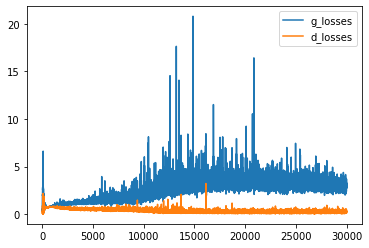

In [ ]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [ ]:
!ls gan_images

0.png	   13800.png  17800.png  21600.png  25600.png  29600.png  6600.png
10000.png  14000.png  18000.png  21800.png  25800.png  29800.png  6800.png
1000.png   1400.png   1800.png	 22000.png  26000.png  3000.png   7000.png
10200.png  14200.png  18200.png  2200.png   2600.png   3200.png   7200.png
10400.png  14400.png  18400.png  22200.png  26200.png  3400.png   7400.png
10600.png  14600.png  18600.png  22400.png  26400.png  3600.png   7600.png
10800.png  14800.png  18800.png  22600.png  26600.png  3800.png   7800.png
11000.png  15000.png  19000.png  22800.png  26800.png  4000.png   8000.png
11200.png  15200.png  19200.png  23000.png  27000.png  400.png	  800.png
11400.png  15400.png  19400.png  23200.png  27200.png  4200.png   8200.png
11600.png  15600.png  19600.png  23400.png  27400.png  4400.png   8400.png
11800.png  15800.png  19800.png  23600.png  27600.png  4600.png   8600.png
12000.png  16000.png  20000.png  23800.png  27800.png  4800.png   8800.png
1200.png   1600.png   2000.png

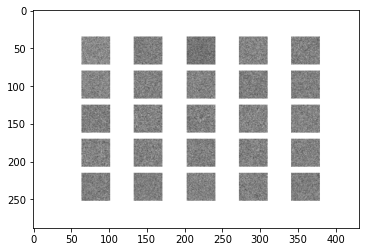

In [ ]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

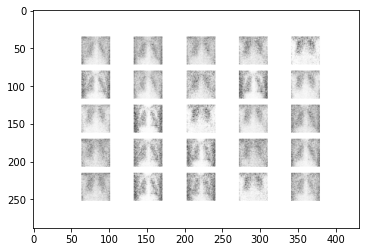

In [ ]:
a = imread('gan_images/1000.png')
plt.imshow(a)

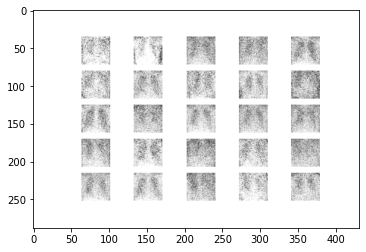

In [ ]:
a = imread('gan_images/5000.png')
plt.imshow(a)

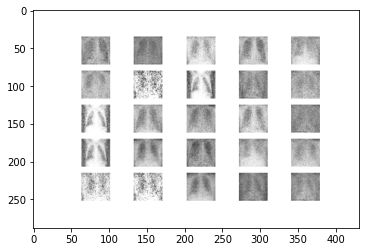

In [ ]:
a = imread('gan_images/10000.png')
plt.imshow(a)

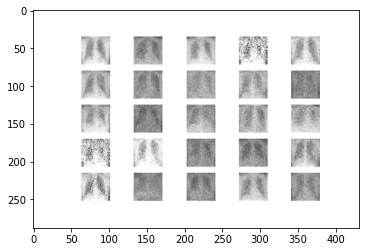

In [ ]:
a = imread('gan_images/9800.png')
plt.imshow(a)